# Random search and hyperparameter scaling with SageMaker XGBoost and Automatic Model Tuning

### Contents
- Introduction
- Preparation
- Download and prepare the data
- Setup hyperparameter tuning
- Logarithmic scaling
- Random search
- Linear scaling

## Introduction
The goal is to implement a hyperparameter tuned model to predict the bank customers likely to sign a loan.

This notebook showcases the use of two hyperparameter tuning features: random search and hyperparameter scaling.

We will use SageMaker Python SDK, a high level SDK, to simplify the way we interact with SageMaker Hyperparameter Tuning.

## S3 Data and IAM Role Preparation
Let's start by specifying:

The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as SageMaker training.
The IAM role used to give training access to your data. See SageMaker documentation for how to create these.

In [1]:
!pip install -U seaborn

Keyring is skipped due to an exception: 'keyring.backends'


In [2]:
import sagemaker
import boto3
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

import numpy as np  # For matrix operations and numerical processing
import pandas as pd  # For munging tabular data
import os
from time import gmtime, strftime

import seaborn as sns
import matplotlib.pyplot as plt
import zipfile

In [3]:
region = boto3.Session().region_name
smclient = boto3.Session().client("sagemaker")

role = sagemaker.get_execution_role()

#bucket = sagemaker.Session().default_bucket()
bucket = "bank-marketing-ml-sagemaker"
prefix = "sagemaker/DEMO-hpo-xgboost-dm"

In [4]:
pd.set_option("display.max_columns", 500)  # Make sure we can see all of the columns
pd.set_option("display.max_rows", 50)  # Keep the output on one page

## Download and prepare the data
Here we download the direct marketing dataset from UCI's ML Repository.

Data Set Information:

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

There are four datasets:
- bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014]
- bank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs.
- bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs).
- bank.csv with 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs).
The smallest datasets are provided to test more computationally demanding machine learning algorithms (e.g., SVM).

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

In [5]:
#!wget -N https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
#!unzip -o data.zip

Now let us load the data, apply some preprocessing, and upload the processed data to s3

In [6]:
# Load data
data = pd.read_csv("./data/bank-additional-full.csv", sep=";")

## Exploratory Data Analysis

In [7]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Attribute Information:

Input variables:

bank client data:
- age (numeric)
- job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
- default: has credit in default? (categorical: 'no','yes','unknown')
- housing: has housing loan? (categorical: 'no','yes','unknown')
- loan: has personal loan? (categorical: 'no','yes','unknown')

related with the last contact of the current campaign:
- contact: contact communication type (categorical: 'cellular','telephone')
- month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

other attributes:
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

social and economic context attributes
- emp.var.rate: employment variation rate - quarterly indicator (numeric)
- cons.price.idx: consumer price index - monthly indicator (numeric)
- cons.conf.idx: consumer confidence index - monthly indicator (numeric)
- euribor3m: euribor 3 month rate - daily indicator (numeric)
- nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
- y - has the client subscribed a term deposit? (binary: 'yes','no')


Relevant Papers:
- S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014
- S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimaraes, Portugal, October, 2011. EUROSIS.

In [8]:
# columns that should not be included in the input
data = data.drop(
    ["duration", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"],
    axis=1,
)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          41188 non-null  int64 
 1   job          41188 non-null  object
 2   marital      41188 non-null  object
 3   education    41188 non-null  object
 4   default      41188 non-null  object
 5   housing      41188 non-null  object
 6   loan         41188 non-null  object
 7   contact      41188 non-null  object
 8   month        41188 non-null  object
 9   day_of_week  41188 non-null  object
 10  campaign     41188 non-null  int64 
 11  pdays        41188 non-null  int64 
 12  previous     41188 non-null  int64 
 13  poutcome     41188 non-null  object
 14  y            41188 non-null  object
dtypes: int64(4), object(11)
memory usage: 4.7+ MB


In [10]:
# seperate data into numeric and categorical columns
numeric_columns = data.select_dtypes(include=np.number).columns.tolist()
numeric_columns

['age', 'campaign', 'pdays', 'previous']

In [11]:
categorical_columns = data.select_dtypes(exclude=np.number).columns.tolist()
categorical_columns

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome',
 'y']

## Feature Engineering

In [12]:
# Apply some feature processing
data["no_previous_contact"] = np.where(
    data["pdays"] == 999, 1, 0
)  # Indicator variable to capture when pdays takes a value of 999
data["not_working"] = np.where(
    np.in1d(data["job"], ["student", "retired", "unemployed"]), 1, 0
)  # Indicator for individuals not actively employed
model_data = pd.get_dummies(data)  # Convert categorical variables to sets of indicators



In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   age                  41188 non-null  int64 
 1   job                  41188 non-null  object
 2   marital              41188 non-null  object
 3   education            41188 non-null  object
 4   default              41188 non-null  object
 5   housing              41188 non-null  object
 6   loan                 41188 non-null  object
 7   contact              41188 non-null  object
 8   month                41188 non-null  object
 9   day_of_week          41188 non-null  object
 10  campaign             41188 non-null  int64 
 11  pdays                41188 non-null  int64 
 12  previous             41188 non-null  int64 
 13  poutcome             41188 non-null  object
 14  y                    41188 non-null  object
 15  no_previous_contact  41188 non-null  int64 
 16  not_

## Prepare for Modeling
### Train test split

In [14]:
# split data
train_data, validation_data, test_data = np.split(
    model_data.sample(frac=1, random_state=1729),
    [int(0.7 * len(model_data)), int(0.9 * len(model_data))],
)

# save preprocessed file to data folder
df_train = pd.concat([test_data["y_yes"], test_data.drop(["y_no", "y_yes"], axis=1)], axis=1)
df_train.to_csv("./data/train.csv", index=False, header=False)

df_validation = pd.concat([validation_data["y_yes"], validation_data.drop(["y_no", "y_yes"], axis=1)], axis=1)
df_validation.to_csv("./data/validation.csv", index=False, header=False)

df_test = pd.concat([test_data["y_yes"], test_data.drop(["y_no", "y_yes"], axis=1)], axis=1)
df_test.to_csv("./data/test.csv", index=False, header=False)


# save preprocessed file to s3
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "train/train.csv")
).upload_file("./data/train.csv")

boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "validation/validation.csv")
).upload_file("./data/validation.csv")

In [15]:
# input for SageMaker

from sagemaker.inputs import TrainingInput

s3_input_train = TrainingInput(
    s3_data="s3://{}/{}/train".format(bucket, prefix), content_type="csv"
)

s3_input_validation = TrainingInput(
    s3_data="s3://{}/{}/validation".format(bucket, prefix), content_type="csv"
)

In [16]:
s3_input_train

## Setup hyperparameter tuning
In this example, we are using SageMaker Python SDK to set up and manage the hyperparameter tuning job. We first configure the training jobs the hyperparameter tuning job will launch by initiating an estimator, and define the static hyperparameter and objective

In [17]:
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.image_uris import retrieve

sess = sagemaker.Session()

container = retrieve("xgboost", region, "latest")

xgb = sagemaker.estimator.Estimator(
    container,
    role,
    base_job_name="xgboost-random-search",
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sess,
)

xgb.set_hyperparameters(
    eval_metric="auc",
    objective="binary:logistic",
    num_round=10,
    rate_drop=0.3,
    tweedie_variance_power=1.4,
)

objective_metric_name = "validation:auc"

## Logarithmic scaling
In both cases we use logarithmic scaling, which is the scaling type that should be used whenever the order of magnitude is more important that the absolute value. It should be used if a change, say, from 1 to 2 is expected to have a much bigger impact than a change from 100 to 101, due to the fact that the hyperparameter doubles in the first case but not in the latter.

In [18]:
hyperparameter_ranges = {
    "alpha": ContinuousParameter(0.01, 10, scaling_type="Logarithmic"),
    "lambda": ContinuousParameter(0.01, 10, scaling_type="Logarithmic"),
    "max_depth": IntegerParameter(1,20, scaling_type="Logarithmic"),
    "colsample_bytree": ContinuousParameter(0.5, 1, scaling_type="Logarithmic")
}

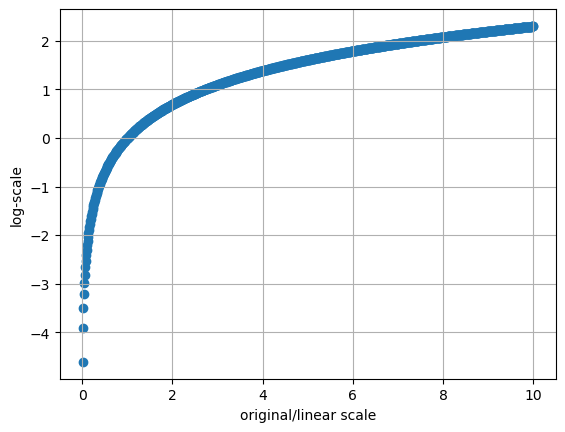

In [19]:
# let´s visualize the effect of logarithmic scaling on the transformed stepsize
x = np.arange(0.01, 10, 0.01)
y = np.log(x)
plt.scatter(x, y)
plt.xlabel('original/linear scale')
plt.ylabel('log-scale')
plt.grid()
plt.show()

## Random search
We now start a tuning job using random search. The main advantage of using random search is that this allows us to train jobs with a high level of parallelism

In [20]:
tuner_log = HyperparameterTuner(
    xgb,
    objective_metric_name,
    hyperparameter_ranges,
    max_jobs=5,
    max_parallel_jobs=5,
    strategy="Random",
)

tuner_log.fit(
    {"train": s3_input_train, "validation": s3_input_validation},
    include_cls_metadata=False,
    job_name="xgb-randsearch-" + strftime("%Y%m%d-%H-%M-%S", gmtime()),
)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.......................................................!


Let's just run a quick check of the hyperparameter tuning jobs status to make sure it started successfully.

In [21]:
boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_log.latest_tuning_job.job_name
)["HyperParameterTuningJobStatus"]

'Completed'

## Linear scaling
Let us compare the results with executing a job using linear scaling.

In [22]:
hyperparameter_ranges_linear = {
    "alpha": ContinuousParameter(0.01, 10, scaling_type="Linear"),
    "lambda": ContinuousParameter(0.01, 10, scaling_type="Linear"),
    "max_depth": IntegerParameter(1,20, scaling_type="Linear"),
    "colsample_bytree": ContinuousParameter(0.5, 1, scaling_type="Linear")
}
tuner_linear = HyperparameterTuner(
    xgb,
    objective_metric_name,
    hyperparameter_ranges_linear,
    max_jobs=5,
    max_parallel_jobs=5,
    strategy="Random",
)

tuner_linear.fit(
    {"train": s3_input_train, "validation": s3_input_validation},
    include_cls_metadata=False,
    job_name="xgb-linsearch-" + strftime("%Y%m%d-%H-%M-%S", gmtime()),
)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..............................................................................................................................!


Let's just run a quick check of the hyperparameter tuning jobs status to make sure it started successfully.

In [23]:
boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_linear.latest_tuning_job.job_name
)["HyperParameterTuningJobStatus"]

'Completed'

## Analyze tuning job results - after tuning job is completed
Once the tuning jobs have completed, we can compare the distribution of the hyperparameter configurations chosen in the two cases.

Please refer to "HPO_Analyze_TuningJob_Results.ipynb" to see more example code to analyze the tuning job results.

In [24]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# check jobs have finished
status_log = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_log.latest_tuning_job.job_name
)["HyperParameterTuningJobStatus"]
status_linear = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_linear.latest_tuning_job.job_name
)["HyperParameterTuningJobStatus"]

assert status_log == "Completed", "First must be completed, was {}".format(status_log)
assert status_linear == "Completed", "Second must be completed, was {}".format(status_linear)

df_log = sagemaker.HyperparameterTuningJobAnalytics(
    tuner_log.latest_tuning_job.job_name
).dataframe()
df_linear = sagemaker.HyperparameterTuningJobAnalytics(
    tuner_linear.latest_tuning_job.job_name
).dataframe()
df_log["scaling"] = "log"
df_linear["scaling"] = "linear"
df = pd.concat([df_log, df_linear], ignore_index=True)

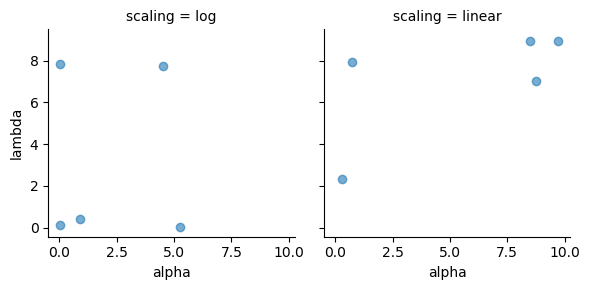

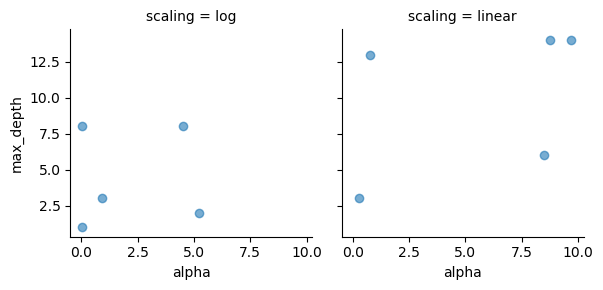

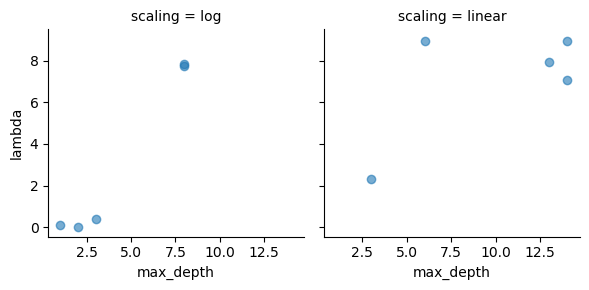

In [25]:
g = sns.FacetGrid(df, col="scaling", palette="viridis")
g = g.map(plt.scatter, "alpha", "lambda", alpha=0.6)
plt.show()

g = sns.FacetGrid(df, col="scaling", palette="viridis")
g = g.map(plt.scatter, "alpha", "max_depth", alpha=0.6)
plt.show()

g = sns.FacetGrid(df, col="scaling", palette="viridis")
g = g.map(plt.scatter, "max_depth", "lambda", alpha=0.6)
plt.show()

## Deploy the best model

In [26]:
# Deploy the model to perform inference 
predictor = tuner_log.deploy(initial_instance_count = 1, 
                             instance_type = 'ml.m5.2xlarge')


2022-12-01 12:05:12 Starting - Preparing the instances for training
2022-12-01 12:05:12 Downloading - Downloading input data
2022-12-01 12:05:12 Training - Training image download completed. Training in progress.
2022-12-01 12:05:12 Uploading - Uploading generated training model
2022-12-01 12:05:12 Completed - Resource retained for reuse
-----!

## Let´s invoke the endpoint using the feature test matrix

In [27]:
# test model on the numpy array
from sagemaker.predictor import csv_serializer, json_deserializer
predictor.serializer = csv_serializer
#predictor.deserializer = json_deserializer

In [28]:
df_test.head()

,y_yes,age,campaign,pdays,previous,no_previous_contact,not_working,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
9637,0,25,1,999,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
36088,1,28,3,999,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0
30101,1,38,1,999,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
36233,1,32,1,999,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
4619,0,40,1,999,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0


In [29]:
# let´s build a feature matrix of type float2
X_test = df_test.drop(['y_yes'], axis=1)
X_test = np.array(X_test).astype('float32')
X_test

array([[ 25.,   1., 999., ...,   0.,   1.,   0.],
       [ 28.,   3., 999., ...,   0.,   1.,   0.],
       [ 38.,   1., 999., ...,   0.,   1.,   0.],
       ...,
       [ 36.,   4., 999., ...,   0.,   1.,   0.],
       [ 42.,   1., 999., ...,   0.,   1.,   0.],
       [ 27.,   1., 999., ...,   0.,   1.,   0.]], dtype=float32)

In [30]:
X_test.shape

(4119, 59)

In [31]:
results = predictor.predict(X_test)
results[:100]

The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


b'0.08915352821350098,0.10887757688760757,0.16379152238368988,0.3143847584724426,0.07565468549728394,0'

In [32]:
def byte2array(prediction_results):
    "take prediction results byte array invoked by the endpoint and turn into numpy array with predicted labels"
    prediction_results = np.fromstring(string=str(prediction_results)[2:-1], dtype=float, count=-1, sep=',')
    return np.where(prediction_results<.5, 0, 1)

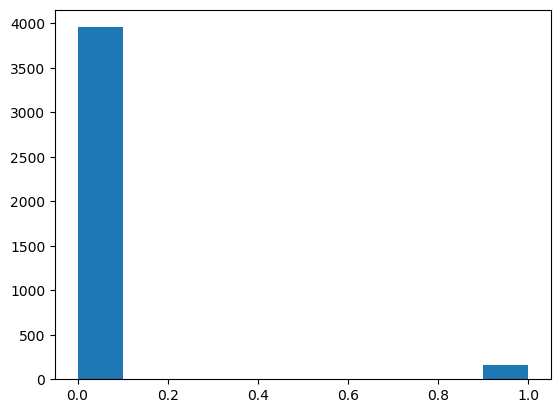

In [33]:
# let´s make a sanity check by looking at the predicted labels
predicted_labels = byte2array(results)
plt.hist(predicted_labels)
plt.show()

## Let´s invoke the endpoint by reading a csv file

In [34]:
# make feature matrices and save as csv
X_train = df_train.drop(['y_yes'], axis=1)
X_train.to_csv("./data/X_train.csv", index=False, header=False)

X_validation = df_validation.drop(['y_yes'], axis=1)
X_validation.to_csv("./data/X_validation.csv", index=False, header=False)

X_test = df_test.drop(['y_yes'], axis=1)
X_test.to_csv("./data/X_test.csv", index=False, header=False)

In [35]:
# Load test data to invoke the endpoint
X_test = pd.read_csv("./data/X_test.csv", sep=",", header=None)
X_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58
0,25,1,999,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
1,28,3,999,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0
2,38,1,999,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,32,1,999,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
4,40,1,999,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0


In [36]:
# predict on csv file
with open('./data/X_test.csv', "r") as f:
    payload = f.read()

In [37]:
results = predictor.predict(payload)
results[:100]

The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


b'0.08915352821350098,0.10887757688760757,0.16379152238368988,0.3143847584724426,0.07565468549728394,0'

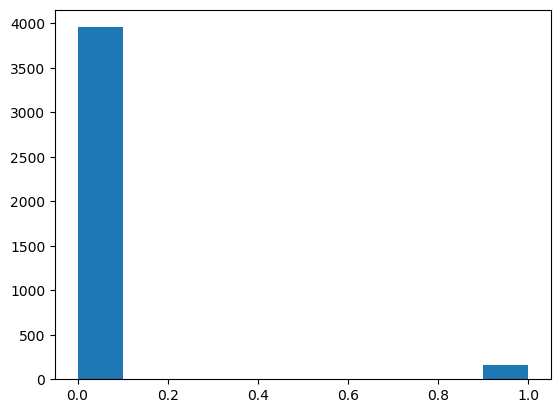

In [38]:
# let´s make a sanity check by looking at the predicted labels
predicted_labels = byte2array(results)
plt.hist(predicted_labels)
plt.show()

In [39]:
# Delete the end-point
predictor.delete_endpoint()